In [104]:
#Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

**Preprocessing**

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
imdb_data = pd.read_csv('/content/drive/My Drive/NLPAssignments/Project/generated_data.csv')
print(imdb_data.shape)
imdb_data.head(10)

(1000, 2)


,review,sentiment
0,paxton awesom hi heel away floor reid typic be...,1
1,raf tenaci spook cattl cultmovieareai process ...,1
2,otherseven thi angl came unnatur truli armi is...,1
3,woman determin self whi purvi wa icon perfect ...,1
4,erot though never introduc wa believ pois self...,1
5,greatest politician time teacher director anyt...,1
6,betti cult follow especi film industri booksho...,1
7,wa mesmer martin shi approach nun held qualiti...,1
8,romant film time blond ani abandon protagonist...,1
9,blackandwhit anyway blood leav mire requir not...,1


In [107]:
imdb_data.describe()

,sentiment
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [108]:
imdb_data['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

In [109]:
X= imdb_data['review']
y = imdb_data['sentiment']


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Generative** **model**

In [111]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_reviews=cv.fit_transform(X_train)
cv_test_reviews=cv.transform(X_test)

print(cv_train_reviews[0].shape)
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

(1, 129990)
BOW_cv_train: (800, 129990)
BOW_cv_test: (200, 129990)


In [113]:
mnb=MultinomialNB()
mnb_bow=mnb.fit(cv_train_reviews,y_train)

In [114]:
mnb_bow_predict=mnb_bow.predict(cv_test_reviews)

In [115]:
mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_bow_score : 0.58


In [116]:
mnb_bow_report=classification_report(y_test,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

              precision    recall  f1-score   support

    Positive       0.59      0.62      0.61       104
    Negative       0.57      0.53      0.55        96

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.58      0.58      0.58       200



In [117]:
cm_bow=confusion_matrix(y_test,mnb_bow_predict)
print(cm_bow)

[[65 39]
 [45 51]]


**Discriminative** **LSTM**

In [147]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from numpy import asarray
from numpy import zeros

In [148]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [149]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [150]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/NLPAssignments/Project/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [151]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [153]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [154]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1412500   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,529,877
Trainable params: 117,377
Non-trainable params: 1,412,500
_________________________________________________________________
None


In [155]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/20
20/20 [==============================] - 2s 123ms/step - loss: 0.6937 - acc: 0.4953 - val_loss: 0.6939 - val_acc: 0.4500
Epoch 2/20
20/20 [==============================] - 2s 88ms/step - loss: 0.6930 - acc: 0.5078 - val_loss: 0.6926 - val_acc: 0.5125
Epoch 3/20
20/20 [==============================] - 2s 88ms/step - loss: 0.6907 - acc: 0.5453 - val_loss: 0.6997 - val_acc: 0.4500
Epoch 4/20
20/20 [==============================] - 2s 87ms/step - loss: 0.6938 - acc: 0.5078 - val_loss: 0.6932 - val_acc: 0.4500
Epoch 5/20
20/20 [==============================] - 2s 86ms/step - loss: 0.6921 - acc: 0.5594 - val_loss: 0.6987 - val_acc: 0.4563
Epoch 6/20
20/20 [==============================] - 2s 88ms/step - loss: 0.6675 - acc: 0.5969 - val_loss: 0.7804 - val_acc: 0.4375
Epoch 7/20
20/20 [==============================] - 2s 88ms/step - loss: 0.6576 - acc: 0.6313 - val_loss: 0.7082 - val_acc: 0.5000
Epoch 8/20
20/20 [==============================] - 2s 89ms/step - loss: 0.6305 - 

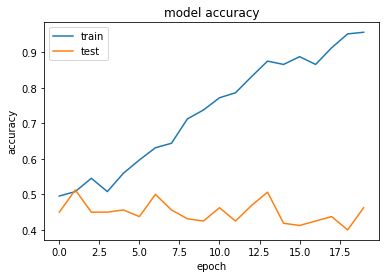

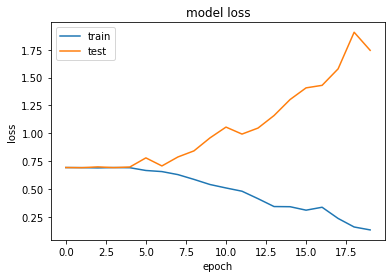

In [156]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [157]:
y_pred = model.predict(X_test)
f = lambda x: 0 if x<0.5 else 1
y_pred = list(map(f, y_pred))

In [158]:
abc = classification_report(y_test, y_pred, target_names=['Negative','Positive'])
print(abc)

              precision    recall  f1-score   support

    Negative       0.51      0.67      0.58       104
    Positive       0.47      0.31      0.38        96

    accuracy                           0.50       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.50      0.48       200



In [159]:
confusion_matrix(y_test, y_pred)

array([[70, 34],
       [66, 30]])